# This notebook focuses on the metadata for bradykinesia

In [1]:
baseDIR = '/home/pataki/synapse/gitParkinson' # base directory of the github repo

In [2]:
cd $baseDIR/sub2.3_brad/

/home/pataki/synapse/gitParkinson/sub2.3_brad


In [3]:
%run -i ../src/helperFuncs.py

In [4]:
%matplotlib inline

In [5]:
mainDF = mainDFCreator('bradykinesiaScore')

Train shape: (3016, 12)
Test shape:  (1409, 12)
Merged:      (4425, 12)


In [6]:
mainDF.groupby('bradykinesiaScore').count()[['site']].rename(columns={'site':'count'})

,count
bradykinesiaScore,
0.0,2234
1.0,782
Score,1409


In [7]:
#returns a heatmap of a pivot table. the two dimensions are the feat1 and feat2. 
#value is the hitRate (#pos/(#pos + #neg))
def featPivot(feat1, feat2, mainDF, vmin, vmax): # vmin, vmax is for the color scale
    tmpDF = mainDF.reset_index(drop=True).reset_index()[['index', feat1, feat2, 'bradykinesiaScore']]
    tmpDF = tmpDF[tmpDF.bradykinesiaScore != 'Score'] # I focus only on 0.0 and 1.0
    tmpDF = tmpDF.groupby([feat1, feat2, 'bradykinesiaScore']).count().reset_index()
    sc1 = tmpDF[tmpDF.bradykinesiaScore == 1.0][[feat1, feat2, 'index']].rename(columns = {'index': 'score1'})
    sc0 = tmpDF[tmpDF.bradykinesiaScore == 0.0][[feat1, feat2, 'index']].rename(columns = {'index': 'score0'})
    tmpDF = pd.merge(sc1, sc0, on = [feat1, feat2], how = 'outer').fillna(0)
    tmpDF['hitRate'] = tmpDF.score1 / (tmpDF.score1 + tmpDF.score0)
    tmpDF = tmpDF.pivot(index = feat1, columns = feat2, values = 'hitRate')

    mask = tmpDF.isnull()
    sns.heatmap(tmpDF, mask = mask, 
                cmap = sns.dark_palette("muted purple", input="xkcd"), vmin = vmin, vmax = vmax)
    plt.show()

## Check the meta features if they contain useful information

['device', 'patient', 'session', 'site', 'task', 'visit', 'deviceSide']


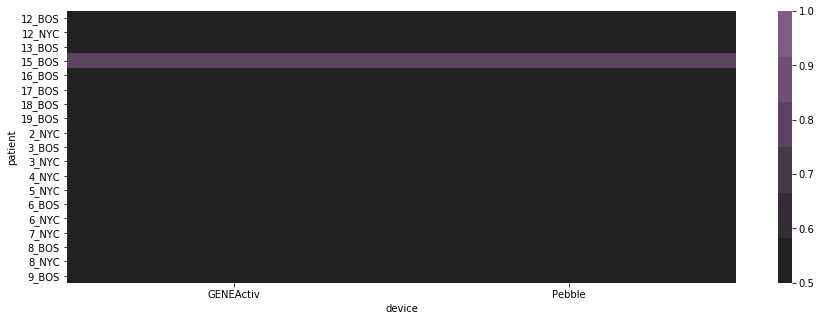

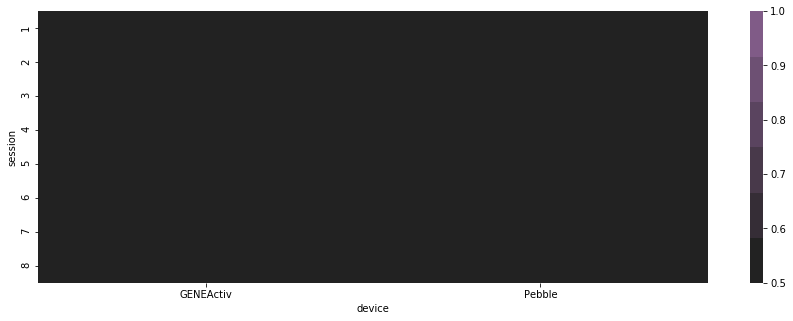

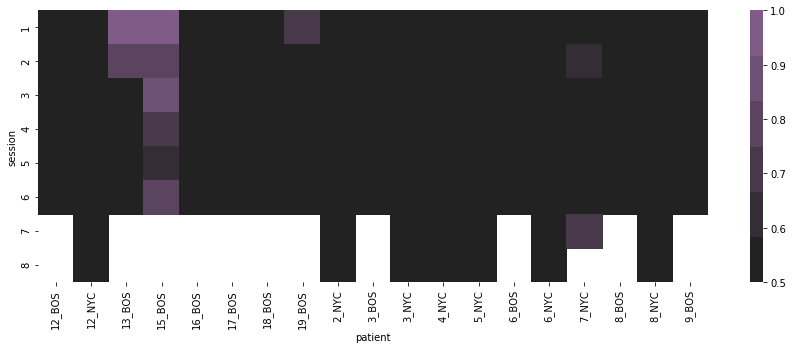

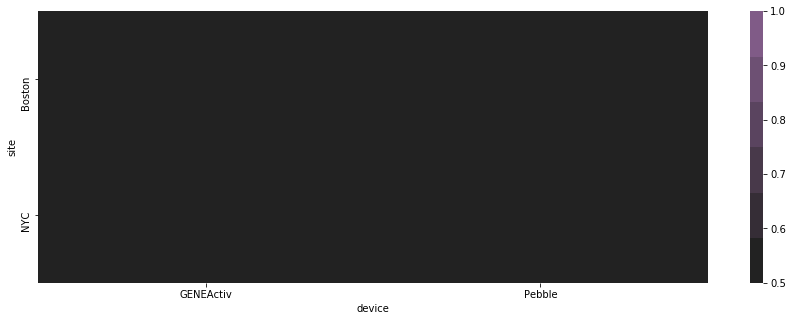

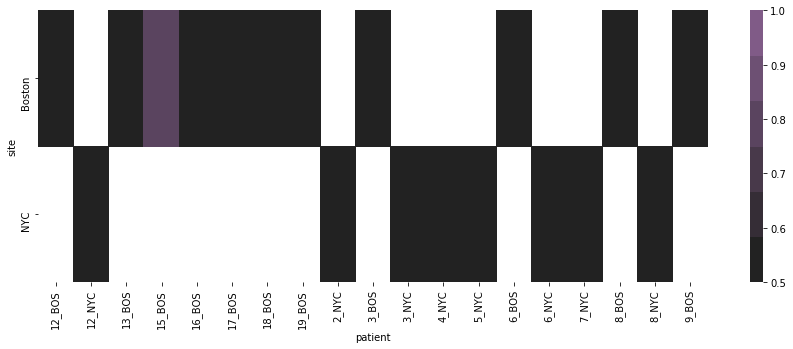

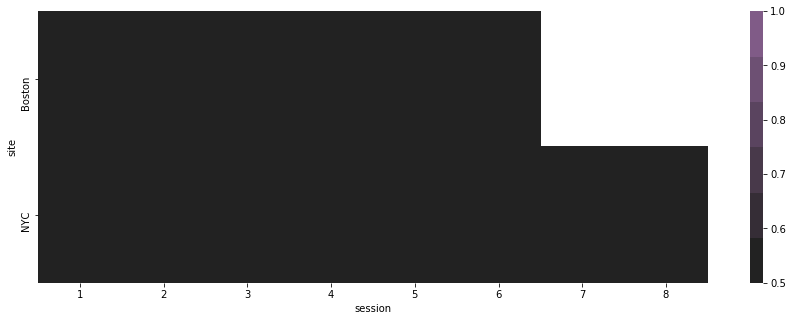

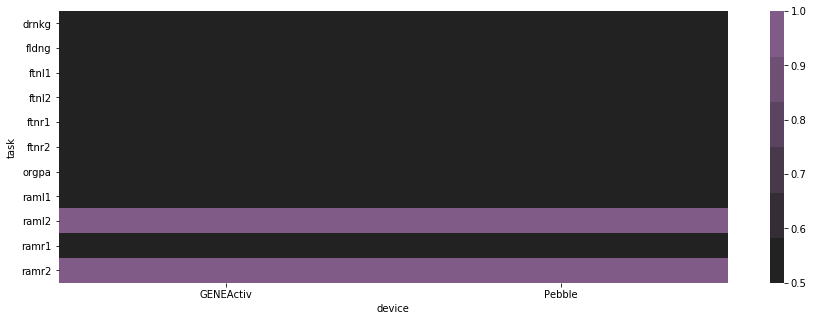

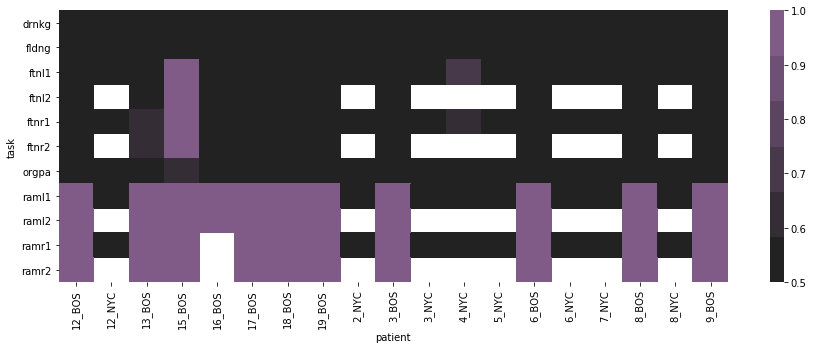

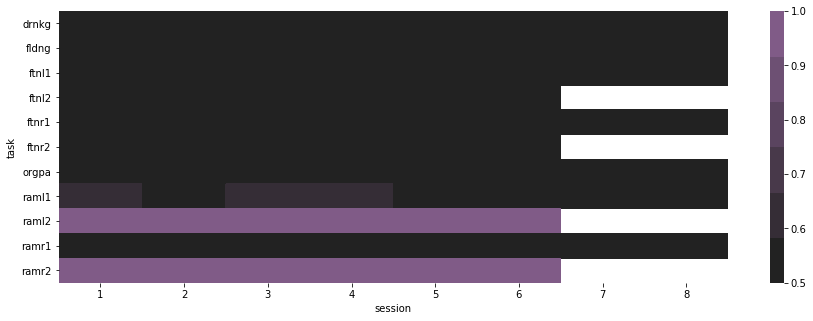

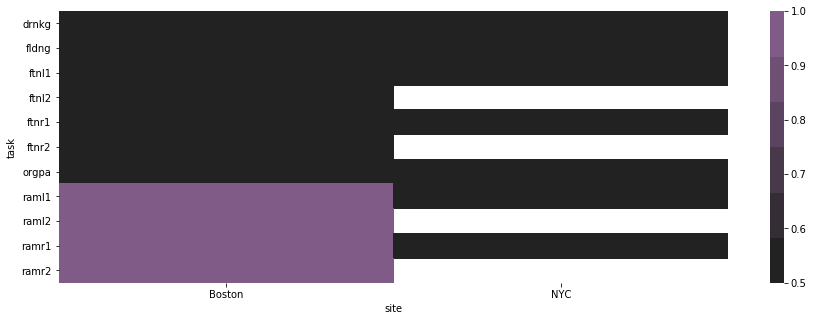

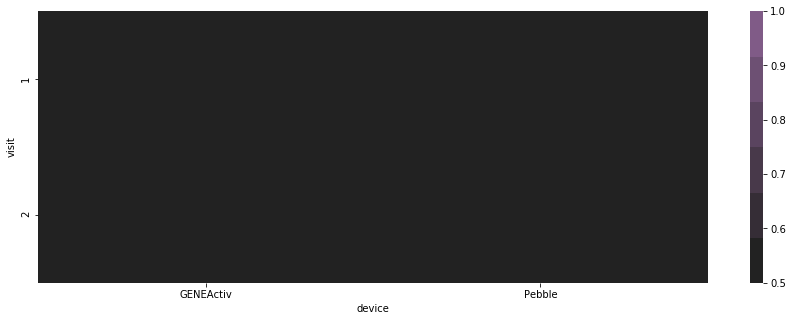

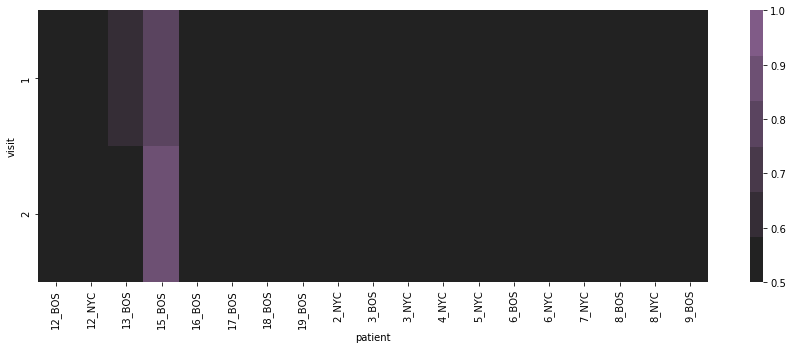

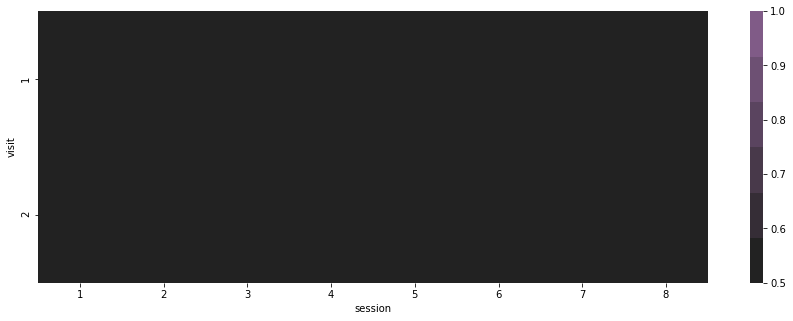

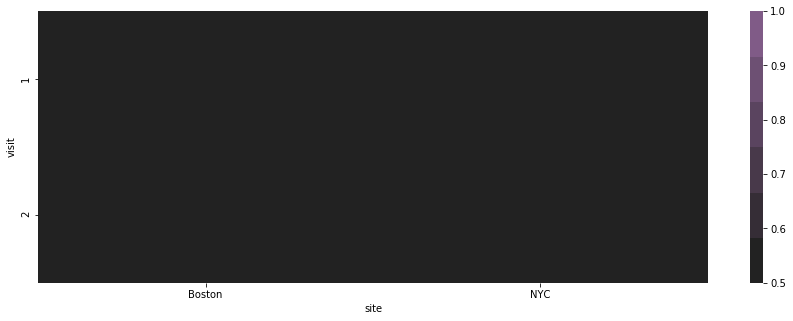

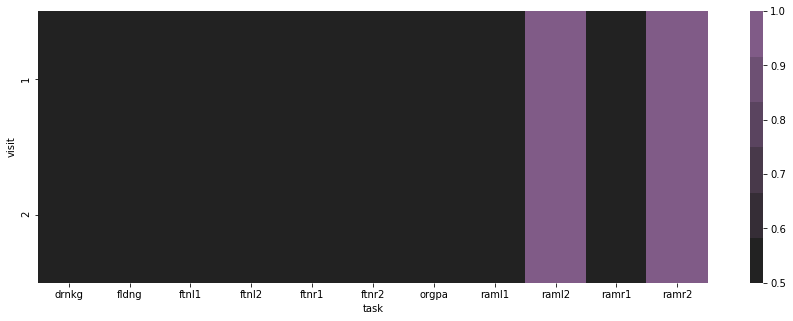

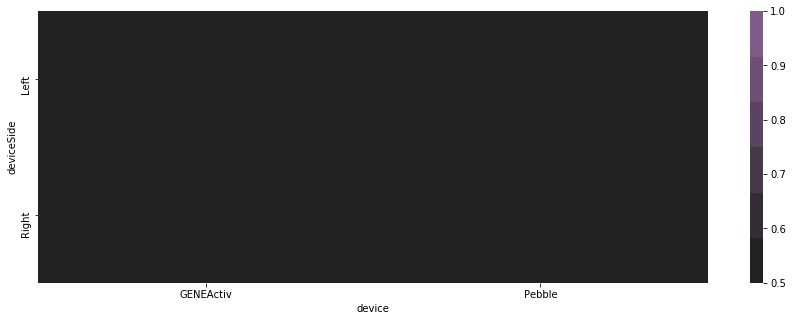

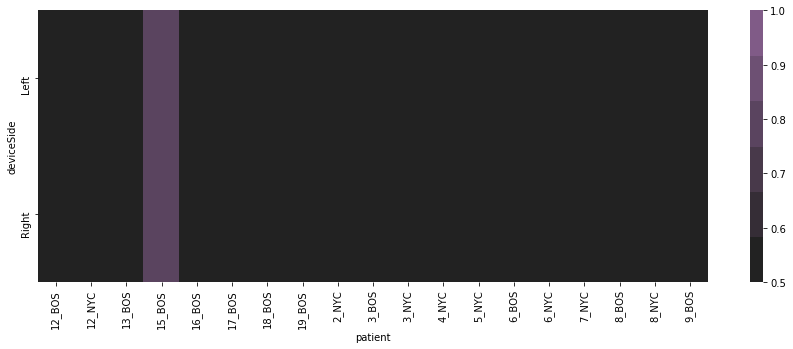

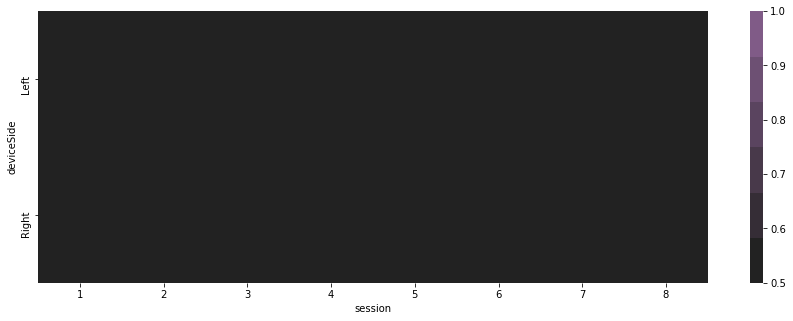

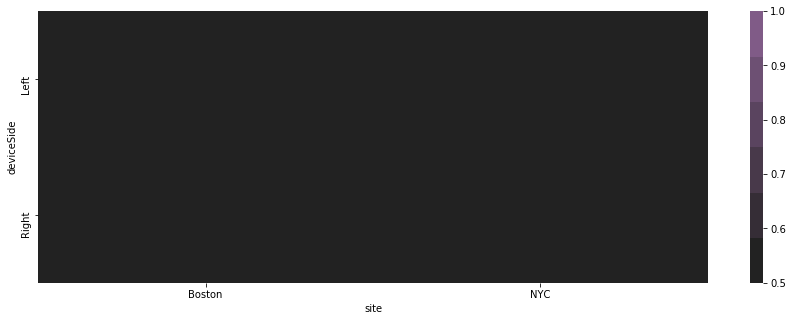

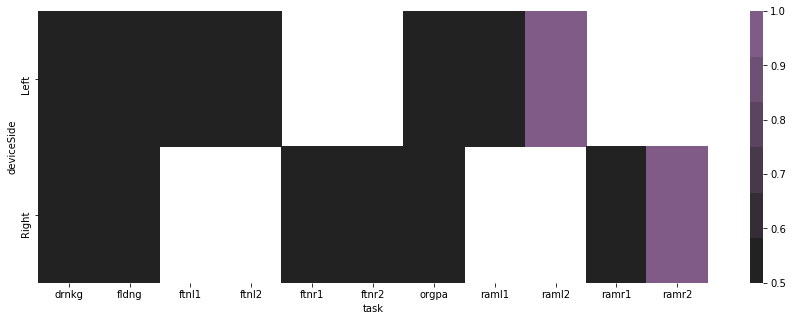

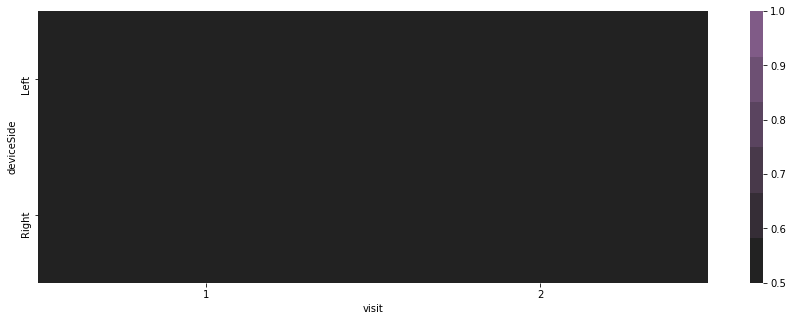

In [8]:
plt.rcParams['figure.figsize']=(15,5)

features = mainDF.columns.tolist()[2:-1]
print(features)
for i in range(len(features)):
    for j in range(len(features)):
        if(i > j):
            plt.subplot()
            subPlot = featPivot(features[i], features[j], mainDF, 0.5, 1.0)

## raml/raml + BOSTON contains only 1.0s

In [9]:
mainDF[mainDF.task.isin(['ramr2', 'raml2', 'ramr1', 'raml1']) 
       & (mainDF.site == 'Boston')].groupby('bradykinesiaScore').count()[['site']].rename(columns={'site':'count'})

,count
bradykinesiaScore,
1.0,446
Score,239


In [10]:
nonTrivial = mainDF[~(mainDF.task.isin(['ramr2', 'raml2', 'ramr1', 'raml1']) & (mainDF.site == 'Boston'))]

In [11]:
nonTrivial.groupby('bradykinesiaScore').count()[['site']].rename(columns={'site':'count'})

,count
bradykinesiaScore,
0.0,2234
1.0,336
Score,1170


## Session if also useful, no need for binarizing this one

In [14]:
count0 = nonTrivial[(nonTrivial.bradykinesiaScore == 0.0) & (nonTrivial.site == 'Boston')].groupby('session').count()[['site']].rename(columns={'site':'BOS0count'}).reset_index()
count1 = nonTrivial[(nonTrivial.bradykinesiaScore == 1.0) & (nonTrivial.site == 'Boston')].groupby('session').count()[['site']].rename(columns={'site':'BOS1count'}).reset_index()

BOSsessDF = pd.merge(count0, count1, on='session')
BOSsessDF['BOShitRate'] = BOSsessDF['BOS1count']/(BOSsessDF['BOS0count'] + BOSsessDF['BOS1count'])

count0 = nonTrivial[(nonTrivial.bradykinesiaScore == 0.0) & (nonTrivial.site == 'NYC')].groupby('session').count()[['site']].rename(columns={'site':'NYC0count'}).reset_index()
count1 = nonTrivial[(nonTrivial.bradykinesiaScore == 1.0) & (nonTrivial.site == 'NYC')].groupby('session').count()[['site']].rename(columns={'site':'NYC1count'}).reset_index()

NYCsessDF = pd.merge(count0, count1, on='session')
NYCsessDF['NYChitRate'] = NYCsessDF['NYC1count']/(NYCsessDF['NYC0count'] + NYCsessDF['NYC1count'])

pd.merge(NYCsessDF, BOSsessDF, on ='session')

,session,NYC0count,NYC1count,NYChitRate,BOS0count,BOS1count,BOShitRate
0,1,112,48,0.30000,148,72,0.327273
1,2,125,35,0.21875,178,42,0.190909
2,3,140,20,0.12500,195,25,0.113636
3,4,147,13,0.08125,206,14,0.063636
4,5,154,6,0.03750,208,12,0.054545
5,6,154,6,0.03750,202,18,0.081818


## empirical feature#1 -> BOS + ramr2/raml2/ramr1/raml1
## empirical feature#2 -> session(1-2)

In [15]:
pos = mainDF[mainDF.task.isin(['ramr2', 'raml2', 'ramr1', 'raml1']) & (mainDF.site == 'Boston')].dataFileHandleId.tolist()
mainDF['empiricalFeature1'] = [1.0 if i in pos else 0.0 for i in mainDF.dataFileHandleId.tolist()]
mainDF['empiricalFeature2'] = [1.0 if i<3 else 0.0 for i in mainDF.session.tolist()]

mainDF = mainDF[['dataFileHandleId', 'empiricalFeature1', 'empiricalFeature2']]

mainDF.head()

,dataFileHandleId,empiricalFeature1,empiricalFeature2
0,17286028,0.0,1.0
1,17286030,0.0,1.0
2,17286034,0.0,1.0
3,17286036,0.0,1.0
5,17286042,0.0,1.0


In [16]:
mainDF.to_csv('featureDB/empiricalFeature.tsv', sep = '\t', index=False)

In [17]:
baseFeatureDF = mainDFCreator('bradykinesiaScore')

Train shape: (3016, 12)
Test shape:  (1409, 12)
Merged:      (4425, 12)


#### binarizing metafeatures except for the session and visit

In [18]:
baseFeatureDF = featureBinarizer(baseFeatureDF, ['device', 'site', 'task', 'deviceSide'])
baseFeatureDF.head()

device ['GENEActiv' 'Pebble']
site ['Boston' 'NYC']
task ['drnkg' 'fldng' 'ftnl1' 'ftnl2' 'ftnr1' 'ftnr2' 'orgpa' 'raml1' 'raml2'
 'ramr1' 'ramr2' 'ntblt']
deviceSide ['Right' 'Left']


,dataFileHandleId,fileName,patient,session,visit,bradykinesiaScore,device_1,site_1,task_1,task_2,...,task_4,task_5,task_6,task_7,task_8,task_9,task_10,task_11,task_12,deviceSide_1
0,17286028,/home/pataki/.synapseCache/28/17286028/drnkg_G...,13_BOS,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,17286030,/home/pataki/.synapseCache/30/17286030/drnkg_P...,13_BOS,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,17286034,/home/pataki/.synapseCache/34/17286034/fldng_G...,13_BOS,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,17286036,/home/pataki/.synapseCache/36/17286036/fldng_P...,13_BOS,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,17286042,/home/pataki/.synapseCache/42/17286042/ftnl1_P...,13_BOS,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
baseFeatureDF.pop('patient');
baseFeatureDF.pop('fileName');
baseFeatureDF.pop('bradykinesiaScore');

In [20]:
baseFeatureDF.to_csv('featureDB/baseFeatures.tsv', sep = '\t', index=False)